<font size ="4">**Importing all the libraries**</font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to /home/u194147/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194147/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [2]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [10]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
true_data = pd.read_csv('data/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [12]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [13]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

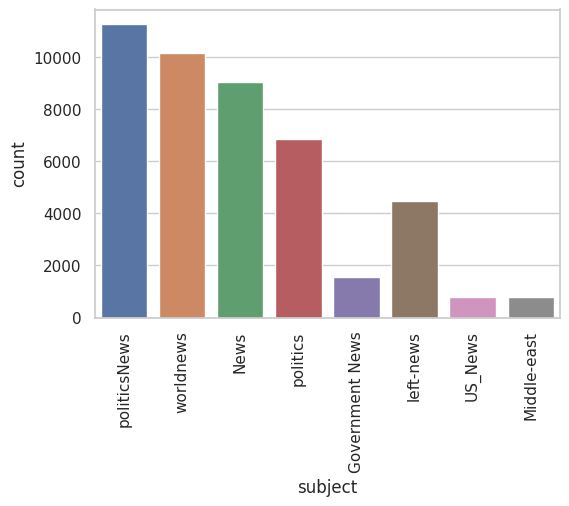

In [14]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [15]:
data['text'] = data['title']+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [16]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [17]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [18]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [19]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,WOW! SECRET SERVICE DIRECTOR Sets Record Strai...,0
1,German SPD says outcome uncertain for impendin...,1
2,Federal Judge Questions Trump’s Legitimacy Af...,0
3,Trump fights release of video testimony in fra...,1
4,"Rubio gets boost from Republican endorsements,...",1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

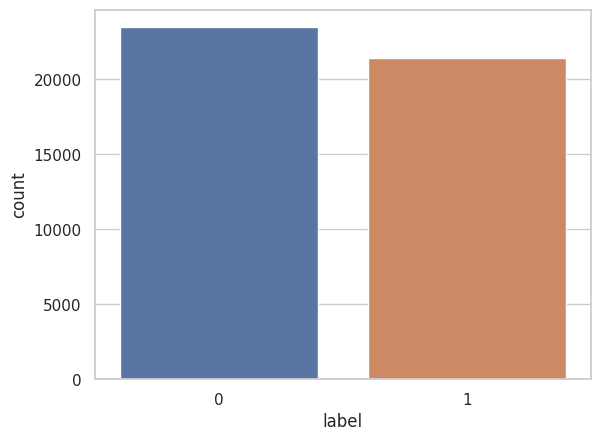

In [20]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [21]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
print(stopwords.words('english'))
port_stem = PorterStemmer()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def preprocess_text(text):
    # TODO: create a function to clean your data 
    preprocess_text = re.sub('[^a-zA-Z]',' ',text)
    preprocess_text = preprocess_text.lower()
    preprocess_text = preprocess_text.split()
    preprocess_text = [port_stem.stem(word) for word in preprocess_text if not word in stopwords.words('english')]
    preprocess_text = ' '.join(preprocess_text)
    return preprocess_text
data['text'] = data['text'].apply(preprocess_text)

In [ ]:
data['text']

<font size="4">**Converting text into Vectors**</font>

In [ ]:
data

In [ ]:
data.to_csv('news.csv', index=False)

print("Dataset saved successfully as news.csv")

In [3]:
news = pd.read_csv("news.csv")

In [4]:
news

,text,label
0,desper clinton grifter go back campaign trailt...,0
1,republican tax vote near senat waverwashington...,1
2,senat panel vote advanc tax billwashington reu...,1
3,hard irish border post brexit would risk peac ...,1
4,trump say good talk obama wednesdaypalm beach ...,1
...,...,...
44893,watch cartoon destroy trump show presidentdona...,0
44894,lip teeth china tie north korea fraybeij reute...,1
44895,flashback undercov video show hillari tell top...,0
44896,trump twitter may nation peac offic memori ser...,1


In [5]:
X = news['text'].values
Y = news['label'].values

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from timeit import default_timer as timer
from sklearnex import patch_sklearn
patch_sklearn()
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
print(X)

  (0, 105660)	0.11558422691870981
  (0, 104270)	0.0815415289324719
  (0, 103941)	0.03147898664089827
  (0, 103717)	0.07729324632682026
  (0, 103471)	0.07490789095935078
  (0, 103357)	0.06874129281887588
  (0, 103109)	0.03545254920143897
  (0, 103047)	0.0814253767962218
  (0, 102796)	0.11349830656196211
  (0, 102733)	0.027585894070768766
  (0, 102666)	0.03370943285535877
  (0, 102134)	0.053314080450610535
  (0, 101478)	0.03501222554965972
  (0, 100800)	0.038265630327623604
  (0, 98808)	0.02638382055049683
  (0, 96703)	0.024937409634498118
  (0, 96244)	0.034549746182313906
  (0, 95493)	0.019235586221358132
  (0, 94792)	0.1260674057809634
  (0, 94178)	0.023853082630834067
  (0, 93616)	0.022423145733277396
  (0, 93194)	0.041227780678444695
  (0, 93063)	0.028851961879817027
  (0, 92657)	0.08572271295980018
  (0, 91105)	0.031086375730340628
  :	:
  (44897, 80851)	0.03588958170264309
  (44897, 78175)	0.04728366151590679
  (44897, 77759)	0.09487415539457839
  (44897, 77022)	0.13392166462267274

In [8]:
print(Y)

[0 1 1 ... 0 1 1]


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

<font size="4"><b>Model training, Evaluation, and Prediction</b></font>

<font size="3"><b>Logistic Regression:</b></font>

In [20]:
patch_sklearn()
start = timer()
modellg = LogisticRegression()
modellg.fit(X_train, Y_train)
train_patched = timer() - start
f"Intel® extension for Scikit-learn time: {train_patched:.2f} s"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


'Intel® extension for Scikit-learn time: 3.08 s'

In [21]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [22]:
start = timer()
model = LogisticRegression()
model.fit(X_train, Y_train)
train_patched = timer() - start
f"Intel® extension for Scikit-learn time: {train_patched:.2f} s"

'Intel® extension for Scikit-learn time: 3.52 s'

In [23]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9888641425389755


In [24]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<font size="3"><b>Decision Tree:</b></font>


In [27]:
from sklearn.tree import DecisionTreeClassifier
patch_sklearn()
start = timer()
DT = DecisionTreeClassifier()
DT.fit(X_train, Y_train)
train_patched = timer() - start
f"Intel® extension for Scikit-learn time: {train_patched:.2f} s"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


'Intel® extension for Scikit-learn time: 25.01 s'

In [29]:
from sklearn.tree import DecisionTreeClassifier
from timeit import default_timer as timer

unpatch_sklearn()
start = timer()
DT = DecisionTreeClassifier()
DT.fit(X_train, Y_train)
train_time = timer() - start
f"Scikit-learn time: {train_time:.2f} s"

'Scikit-learn time: 25.04 s'

In [30]:
pred_dt = DT.predict(X_test)
DT.score(X_test, Y_test)

0.9965478841870824

In [31]:
print(classification_report(Y_test, pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



<font size="3"><b>Random Forest:</b></font>


In [32]:
from sklearn.ensemble import RandomForestClassifier
patch_sklearn()
start = timer()
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, Y_train)
train_patched = timer() - start
f"Intel® extension for Scikit-learn time: {train_patched:.2f} s"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


'Intel® extension for Scikit-learn time: 67.43 s'

In [33]:
unpatch_sklearn()
start = timer()
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, Y_train)
train_patched = timer() - start
f"Scikit-learn time: {train_patched:.2f} s"

'Scikit-learn time: 67.57 s'

In [34]:
rf.predict(X_test)

array([1, 1, 0, ..., 0, 0, 0])

In [35]:
rf.score(X_test, Y_test)

0.9924276169265034

In [36]:
from sklearn.metrics import classification_report

# Generate predictions using the trained Random Forest model
pred_rf = rf.predict(X_test)

# Print the classification report
print(classification_report(Y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<font size="4"><b>Model Comparison</b></font>

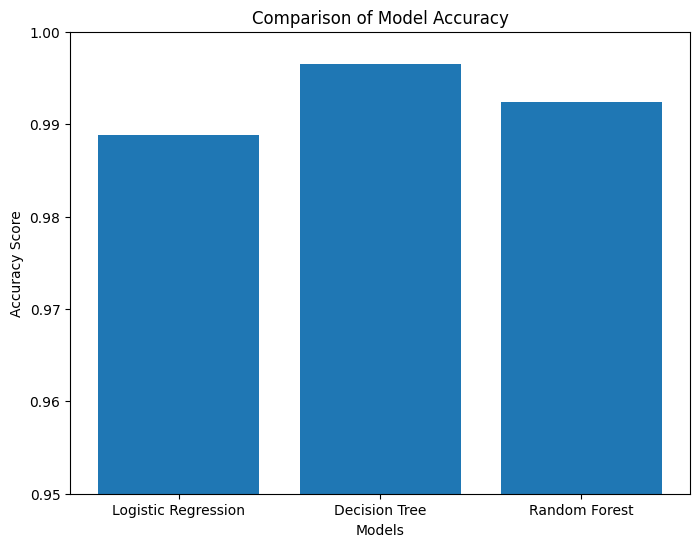

In [37]:
import matplotlib.pyplot as plt

# Accuracy scores for each model
accuracy_scores = [test_data_accuracy, DT.score(X_test, Y_test), rf.score(X_test, Y_test)]

# Model names
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

# Plotting the accuracy scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_scores)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy')
plt.ylim(0.95, 1.0)  # Set the y-axis limits if desired
plt.show()

In [22]:
import pickle
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(modellg, file)

In [23]:
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(DT, file)

In [12]:
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)